In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, UpSampling2D
from keras.layers import Add, merge, DepthwiseConv2D, GlobalAveragePooling2D
from keras.layers.merge import add, concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from model import ResNet152
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
import os

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## path setting 

In [2]:
train_path = './skinimg/train'
valid_path = './skinimg/valid'
test_path = './skinimg/test'

## Image load

In [3]:
dataGen = ImageDataGenerator()
train_batches = dataGen.flow_from_directory(train_path, 
                                            target_size=(1024,1024), 
                                            color_mode='rgb', 
                                            classes=['A', 'B', 'C'], 
                                            batch_size=12, 
                                            shuffle=True)
valid_batches = dataGen.flow_from_directory(valid_path, 
                                            target_size=(1024,1024), 
                                            color_mode='rgb', 
                                            classes=['A', 'B', 'C'], 
                                            batch_size=3, 
                                            shuffle=True)
test_batches = dataGen.flow_from_directory(test_path, 
                                           target_size=(1024,1024), 
                                            batch_size=1, 
                                            shuffle=False)

Found 27 images belonging to 3 classes.
Found 9 images belonging to 3 classes.
Found 15 images belonging to 1 classes.


## Build model 

In [4]:
base_model = ResNet152(include_top=False, weights='imagenet',
              input_tensor=None, input_shape=None, pooling=None, classes=1000)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(120, activation='relu')(x)
out = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)

In [60]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_zeropadding (ZeroPadding2 (None, None, None, 3 0           input_10[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        conv1_zeropadding[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
scale_conv

In [61]:
for i, layer in enumerate(model.layers):
      print(i, layer.name)

0 input_10
1 conv1_zeropadding
2 conv1
3 bn_conv1
4 scale_conv1
5 conv1_relu
6 pool1
7 res2a_branch2a
8 bn2a_branch2a
9 scale2a_branch2a
10 res2a_branch2a_relu
11 res2a_branch2b_zeropadding
12 res2a_branch2b
13 bn2a_branch2b
14 scale2a_branch2b
15 res2a_branch2b_relu
16 res2a_branch2c
17 res2a_branch1
18 bn2a_branch2c
19 bn2a_branch1
20 scale2a_branch2c
21 scale2a_branch1
22 res2a
23 res2a_relu
24 res2b_branch2a
25 bn2b_branch2a
26 scale2b_branch2a
27 res2b_branch2a_relu
28 res2b_branch2b_zeropadding
29 res2b_branch2b
30 bn2b_branch2b
31 scale2b_branch2b
32 res2b_branch2b_relu
33 res2b_branch2c
34 bn2b_branch2c
35 scale2b_branch2c
36 res2b
37 res2b_relu
38 res2c_branch2a
39 bn2c_branch2a
40 scale2c_branch2a
41 res2c_branch2a_relu
42 res2c_branch2b_zeropadding
43 res2c_branch2b
44 bn2c_branch2b
45 scale2c_branch2b
46 res2c_branch2b_relu
47 res2c_branch2c
48 bn2c_branch2c
49 scale2c_branch2c
50 res2c
51 res2c_relu
52 res3a_branch2a
53 bn3a_branch2a
54 scale3a_branch2a
55 res3a_branch2a_r

## Training 

In [5]:
for layer in model.layers[:-3]:
    layer.trainable=False
for layer in model.layers[-3:]:
    layer.trainable=True

In [6]:
%%time
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy

step_size_train = train_batches.n // train_batches.batch_size
model.fit_generator(generator=train_batches, 
                    steps_per_epoch=step_size_train, 
                    validation_data=valid_batches, 
                    validation_steps=1, 
                    epochs=1000, 
                    verbose=2)

Epoch 1/1000
 - 13s - loss: 1.2215 - acc: 0.5167 - val_loss: 1.8921 - val_acc: 0.6667
Epoch 2/1000
 - 7s - loss: 1.8773 - acc: 0.2917 - val_loss: 1.4515 - val_acc: 0.0000e+00
Epoch 3/1000
 - 5s - loss: 1.2045 - acc: 0.2333 - val_loss: 2.3084 - val_acc: 0.0000e+00
Epoch 4/1000
 - 5s - loss: 1.2610 - acc: 0.3833 - val_loss: 2.4044 - val_acc: 0.0000e+00
Epoch 5/1000
 - 5s - loss: 1.2559 - acc: 0.4667 - val_loss: 1.9521 - val_acc: 0.0000e+00
Epoch 6/1000
 - 9s - loss: 0.9951 - acc: 0.5417 - val_loss: 1.8008 - val_acc: 0.6667
Epoch 7/1000
 - 8s - loss: 1.0211 - acc: 0.3750 - val_loss: 1.6111 - val_acc: 0.6667
Epoch 8/1000
 - 3s - loss: 0.6836 - acc: 0.6667 - val_loss: 1.4762 - val_acc: 0.6667
Epoch 9/1000
 - 9s - loss: 0.9764 - acc: 0.4167 - val_loss: 1.4205 - val_acc: 0.6667
Epoch 10/1000
 - 4s - loss: 0.9027 - acc: 0.3333 - val_loss: 1.4764 - val_acc: 0.6667
Epoch 11/1000
 - 5s - loss: 0.6011 - acc: 0.8500 - val_loss: 1.8212 - val_acc: 0.0000e+00
Epoch 12/1000
 - 9s - loss: 0.6400 - acc: 

Epoch 93/1000
 - 5s - loss: 0.1557 - acc: 1.0000 - val_loss: 3.2976 - val_acc: 0.0000e+00
Epoch 94/1000
 - 9s - loss: 0.1444 - acc: 1.0000 - val_loss: 4.0642 - val_acc: 0.0000e+00
Epoch 95/1000
 - 7s - loss: 0.5414 - acc: 0.7333 - val_loss: 3.4660 - val_acc: 0.0000e+00
Epoch 96/1000
 - 5s - loss: 0.3599 - acc: 0.7167 - val_loss: 2.7724 - val_acc: 0.0000e+00
Epoch 97/1000
 - 5s - loss: 0.5139 - acc: 0.8000 - val_loss: 2.3344 - val_acc: 0.0000e+00
Epoch 98/1000
 - 9s - loss: 0.0612 - acc: 1.0000 - val_loss: 2.0535 - val_acc: 0.3333
Epoch 99/1000
 - 4s - loss: 0.6002 - acc: 0.6833 - val_loss: 2.3950 - val_acc: 0.3333
Epoch 100/1000
 - 5s - loss: 0.3151 - acc: 0.8667 - val_loss: 3.4934 - val_acc: 0.0000e+00
Epoch 101/1000
 - 9s - loss: 0.1272 - acc: 1.0000 - val_loss: 4.6817 - val_acc: 0.0000e+00
Epoch 102/1000
 - 5s - loss: 0.1168 - acc: 1.0000 - val_loss: 5.3402 - val_acc: 0.0000e+00
Epoch 103/1000
 - 5s - loss: 0.2023 - acc: 0.8667 - val_loss: 5.3044 - val_acc: 0.0000e+00
Epoch 104/1000

Epoch 184/1000
 - 5s - loss: 0.0508 - acc: 1.0000 - val_loss: 4.5581 - val_acc: 0.0000e+00
Epoch 185/1000
 - 8s - loss: 0.0509 - acc: 1.0000 - val_loss: 5.2869 - val_acc: 0.0000e+00
Epoch 186/1000
 - 5s - loss: 0.4027 - acc: 0.7167 - val_loss: 5.1214 - val_acc: 0.0000e+00
Epoch 187/1000
 - 6s - loss: 0.4453 - acc: 0.8667 - val_loss: 3.8984 - val_acc: 0.0000e+00
Epoch 188/1000
 - 8s - loss: 0.0266 - acc: 1.0000 - val_loss: 3.1573 - val_acc: 0.6667
Epoch 189/1000
 - 5s - loss: 0.5039 - acc: 0.7500 - val_loss: 2.9369 - val_acc: 0.6667
Epoch 190/1000
 - 5s - loss: 0.2842 - acc: 0.8500 - val_loss: 2.5133 - val_acc: 0.6667
Epoch 191/1000
 - 9s - loss: 0.0306 - acc: 1.0000 - val_loss: 2.3492 - val_acc: 0.0000e+00
Epoch 192/1000
 - 5s - loss: 0.0588 - acc: 1.0000 - val_loss: 2.4604 - val_acc: 0.0000e+00
Epoch 193/1000
 - 5s - loss: 0.1149 - acc: 0.9500 - val_loss: 2.6148 - val_acc: 0.0000e+00
Epoch 194/1000
 - 9s - loss: 0.0893 - acc: 1.0000 - val_loss: 2.7622 - val_acc: 0.0000e+00
Epoch 195/1

Epoch 275/1000
 - 9s - loss: 0.1737 - acc: 0.9167 - val_loss: 3.1679 - val_acc: 0.3333
Epoch 276/1000
 - 4s - loss: 0.0946 - acc: 1.0000 - val_loss: 2.6397 - val_acc: 0.0000e+00
Epoch 277/1000
 - 5s - loss: 0.0362 - acc: 1.0000 - val_loss: 2.3116 - val_acc: 0.0000e+00
Epoch 278/1000
 - 5s - loss: 0.1376 - acc: 1.0000 - val_loss: 2.3025 - val_acc: 0.0000e+00
Epoch 279/1000
 - 9s - loss: 0.0452 - acc: 1.0000 - val_loss: 2.4134 - val_acc: 0.0000e+00
Epoch 280/1000
 - 5s - loss: 0.1020 - acc: 1.0000 - val_loss: 2.6481 - val_acc: 0.0000e+00
Epoch 281/1000
 - 4s - loss: 0.0760 - acc: 1.0000 - val_loss: 2.8452 - val_acc: 0.0000e+00
Epoch 282/1000
 - 9s - loss: 0.0099 - acc: 1.0000 - val_loss: 3.0191 - val_acc: 0.0000e+00
Epoch 283/1000
 - 8s - loss: 0.0077 - acc: 1.0000 - val_loss: 3.1684 - val_acc: 0.0000e+00
Epoch 284/1000
 - 3s - loss: 0.0514 - acc: 1.0000 - val_loss: 3.3263 - val_acc: 0.0000e+00
Epoch 285/1000
 - 9s - loss: 0.0179 - acc: 1.0000 - val_loss: 3.4904 - val_acc: 0.0000e+00
Epo

Epoch 366/1000
 - 4s - loss: 0.0171 - acc: 1.0000 - val_loss: 4.0938 - val_acc: 0.0000e+00
Epoch 367/1000
 - 9s - loss: 0.0041 - acc: 1.0000 - val_loss: 3.4010 - val_acc: 0.0000e+00
Epoch 368/1000
 - 3s - loss: 0.0778 - acc: 1.0000 - val_loss: 2.9865 - val_acc: 0.6667
Epoch 369/1000
 - 9s - loss: 0.0362 - acc: 1.0000 - val_loss: 2.8926 - val_acc: 0.6667
Epoch 370/1000
 - 4s - loss: 0.0788 - acc: 1.0000 - val_loss: 2.8453 - val_acc: 0.6667
Epoch 371/1000
 - 5s - loss: 0.1894 - acc: 0.9500 - val_loss: 2.7106 - val_acc: 0.6667
Epoch 372/1000
 - 9s - loss: 0.0195 - acc: 1.0000 - val_loss: 2.7359 - val_acc: 0.3333
Epoch 373/1000
 - 5s - loss: 0.0125 - acc: 1.0000 - val_loss: 2.9290 - val_acc: 0.0000e+00
Epoch 374/1000
 - 5s - loss: 0.0050 - acc: 1.0000 - val_loss: 3.1913 - val_acc: 0.0000e+00
Epoch 375/1000
 - 9s - loss: 0.0157 - acc: 1.0000 - val_loss: 3.4402 - val_acc: 0.0000e+00
Epoch 376/1000
 - 8s - loss: 0.0131 - acc: 1.0000 - val_loss: 3.6390 - val_acc: 0.0000e+00
Epoch 377/1000
 - 7

Epoch 457/1000
 - 8s - loss: 0.0027 - acc: 1.0000 - val_loss: 3.7606 - val_acc: 0.0000e+00
Epoch 458/1000
 - 3s - loss: 0.0469 - acc: 1.0000 - val_loss: 3.9529 - val_acc: 0.0000e+00
Epoch 459/1000
 - 9s - loss: 0.0023 - acc: 1.0000 - val_loss: 4.0920 - val_acc: 0.0000e+00
Epoch 460/1000
 - 5s - loss: 0.0045 - acc: 1.0000 - val_loss: 4.2008 - val_acc: 0.0000e+00
Epoch 461/1000
 - 5s - loss: 0.0029 - acc: 1.0000 - val_loss: 4.2905 - val_acc: 0.0000e+00
Epoch 462/1000
 - 9s - loss: 0.0025 - acc: 1.0000 - val_loss: 4.3639 - val_acc: 0.0000e+00
Epoch 463/1000
 - 8s - loss: 0.0013 - acc: 1.0000 - val_loss: 4.4242 - val_acc: 0.0000e+00
Epoch 464/1000
 - 3s - loss: 0.8819 - acc: 0.6667 - val_loss: 3.9105 - val_acc: 0.0000e+00
Epoch 465/1000
 - 9s - loss: 0.0241 - acc: 1.0000 - val_loss: 3.5203 - val_acc: 0.0000e+00
Epoch 466/1000
 - 8s - loss: 0.1050 - acc: 0.9583 - val_loss: 3.2817 - val_acc: 0.0000e+00
Epoch 467/1000
 - 3s - loss: 1.6311 - acc: 0.3333 - val_loss: 4.8797 - val_acc: 0.0000e+00

Epoch 548/1000
 - 4s - loss: 0.0016 - acc: 1.0000 - val_loss: 3.7410 - val_acc: 0.0000e+00
Epoch 549/1000
 - 9s - loss: 0.0331 - acc: 1.0000 - val_loss: 3.9369 - val_acc: 0.0000e+00
Epoch 550/1000
 - 8s - loss: 0.0065 - acc: 1.0000 - val_loss: 4.1030 - val_acc: 0.0000e+00
Epoch 551/1000
 - 7s - loss: 0.0018 - acc: 1.0000 - val_loss: 4.2412 - val_acc: 0.0000e+00
Epoch 552/1000
 - 4s - loss: 0.0238 - acc: 1.0000 - val_loss: 4.4044 - val_acc: 0.0000e+00
Epoch 553/1000
 - 5s - loss: 0.0353 - acc: 1.0000 - val_loss: 4.5205 - val_acc: 0.0000e+00
Epoch 554/1000
 - 5s - loss: 0.0195 - acc: 1.0000 - val_loss: 4.5059 - val_acc: 0.0000e+00
Epoch 555/1000
 - 9s - loss: 0.0080 - acc: 1.0000 - val_loss: 4.4578 - val_acc: 0.0000e+00
Epoch 556/1000
 - 5s - loss: 0.0040 - acc: 1.0000 - val_loss: 4.4295 - val_acc: 0.0000e+00
Epoch 557/1000
 - 8s - loss: 0.0024 - acc: 1.0000 - val_loss: 4.4054 - val_acc: 0.0000e+00
Epoch 558/1000
 - 5s - loss: 0.0013 - acc: 1.0000 - val_loss: 4.3914 - val_acc: 0.0000e+00

Epoch 639/1000
 - 5s - loss: 0.0754 - acc: 1.0000 - val_loss: 3.8869 - val_acc: 0.0000e+00
Epoch 640/1000
 - 5s - loss: 0.0198 - acc: 1.0000 - val_loss: 4.1767 - val_acc: 0.0000e+00
Epoch 641/1000
 - 9s - loss: 0.0032 - acc: 1.0000 - val_loss: 4.4232 - val_acc: 0.0000e+00
Epoch 642/1000
 - 5s - loss: 0.5486 - acc: 0.7333 - val_loss: 4.1273 - val_acc: 0.0000e+00
Epoch 643/1000
 - 8s - loss: 0.0048 - acc: 1.0000 - val_loss: 3.9529 - val_acc: 0.0000e+00
Epoch 644/1000
 - 7s - loss: 0.9146 - acc: 0.7333 - val_loss: 5.2759 - val_acc: 0.0000e+00
Epoch 645/1000
 - 5s - loss: 0.1225 - acc: 1.0000 - val_loss: 6.2167 - val_acc: 0.0000e+00
Epoch 646/1000
 - 5s - loss: 0.0823 - acc: 1.0000 - val_loss: 6.8183 - val_acc: 0.0000e+00
Epoch 647/1000
 - 9s - loss: 0.1112 - acc: 0.9583 - val_loss: 7.0920 - val_acc: 0.0000e+00
Epoch 648/1000
 - 5s - loss: 0.9613 - acc: 0.7333 - val_loss: 6.6327 - val_acc: 0.0000e+00
Epoch 649/1000
 - 6s - loss: 0.0542 - acc: 1.0000 - val_loss: 5.3170 - val_acc: 0.0000e+00

Epoch 730/1000
 - 6s - loss: 0.0129 - acc: 1.0000 - val_loss: 5.5576 - val_acc: 0.0000e+00
Epoch 731/1000
 - 8s - loss: 0.0026 - acc: 1.0000 - val_loss: 5.4474 - val_acc: 0.0000e+00
Epoch 732/1000
 - 5s - loss: 0.0114 - acc: 1.0000 - val_loss: 5.3589 - val_acc: 0.0000e+00
Epoch 733/1000
 - 9s - loss: 0.0042 - acc: 1.0000 - val_loss: 5.2859 - val_acc: 0.0000e+00
Epoch 734/1000
 - 7s - loss: 0.0039 - acc: 1.0000 - val_loss: 5.2319 - val_acc: 0.0000e+00
Epoch 735/1000
 - 5s - loss: 0.0139 - acc: 1.0000 - val_loss: 5.1635 - val_acc: 0.0000e+00
Epoch 736/1000
 - 5s - loss: 0.0557 - acc: 1.0000 - val_loss: 4.9798 - val_acc: 0.0000e+00
Epoch 737/1000
 - 9s - loss: 0.0031 - acc: 1.0000 - val_loss: 4.6903 - val_acc: 0.0000e+00
Epoch 738/1000
 - 4s - loss: 0.0147 - acc: 1.0000 - val_loss: 4.4616 - val_acc: 0.0000e+00
Epoch 739/1000
 - 6s - loss: 0.0317 - acc: 1.0000 - val_loss: 4.1722 - val_acc: 0.0000e+00
Epoch 740/1000
 - 5s - loss: 0.0531 - acc: 1.0000 - val_loss: 3.8622 - val_acc: 0.0000e+00

Epoch 821/1000
 - 7s - loss: 0.0015 - acc: 1.0000 - val_loss: 4.5435 - val_acc: 0.0000e+00
Epoch 822/1000
 - 5s - loss: 0.0108 - acc: 1.0000 - val_loss: 4.4555 - val_acc: 0.0000e+00
Epoch 823/1000
 - 5s - loss: 0.0044 - acc: 1.0000 - val_loss: 4.4130 - val_acc: 0.0000e+00
Epoch 824/1000
 - 9s - loss: 0.0011 - acc: 1.0000 - val_loss: 4.3878 - val_acc: 0.0000e+00
Epoch 825/1000
 - 5s - loss: 0.0402 - acc: 1.0000 - val_loss: 4.3451 - val_acc: 0.0000e+00
Epoch 826/1000
 - 5s - loss: 0.1773 - acc: 0.8667 - val_loss: 4.7565 - val_acc: 0.0000e+00
Epoch 827/1000
 - 5s - loss: 0.0139 - acc: 1.0000 - val_loss: 5.4314 - val_acc: 0.0000e+00
Epoch 828/1000
 - 9s - loss: 0.0014 - acc: 1.0000 - val_loss: 5.9336 - val_acc: 0.0000e+00
Epoch 829/1000
 - 5s - loss: 0.0162 - acc: 1.0000 - val_loss: 6.2304 - val_acc: 0.0000e+00
Epoch 830/1000
 - 8s - loss: 0.0017 - acc: 1.0000 - val_loss: 6.4319 - val_acc: 0.0000e+00
Epoch 831/1000
 - 5s - loss: 0.0056 - acc: 1.0000 - val_loss: 6.5903 - val_acc: 0.0000e+00

Epoch 912/1000
 - 5s - loss: 0.0233 - acc: 1.0000 - val_loss: 0.8004 - val_acc: 0.6667
Epoch 913/1000
 - 8s - loss: 0.2345 - acc: 0.8750 - val_loss: 0.7864 - val_acc: 0.6667
Epoch 914/1000
 - 7s - loss: 1.5286 - acc: 0.7333 - val_loss: 1.6797 - val_acc: 0.6667
Epoch 915/1000
 - 4s - loss: 0.0985 - acc: 0.9500 - val_loss: 2.7837 - val_acc: 0.0000e+00
Epoch 916/1000
 - 6s - loss: 0.0332 - acc: 1.0000 - val_loss: 3.9796 - val_acc: 0.0000e+00
Epoch 917/1000
 - 8s - loss: 0.0038 - acc: 1.0000 - val_loss: 5.0786 - val_acc: 0.0000e+00
Epoch 918/1000
 - 5s - loss: 0.1545 - acc: 0.8667 - val_loss: 6.3536 - val_acc: 0.0000e+00
Epoch 919/1000
 - 5s - loss: 0.3816 - acc: 0.7333 - val_loss: 6.9207 - val_acc: 0.0000e+00
Epoch 920/1000
 - 9s - loss: 0.0305 - acc: 1.0000 - val_loss: 6.7162 - val_acc: 0.0000e+00
Epoch 921/1000
 - 5s - loss: 0.1552 - acc: 0.9500 - val_loss: 6.4822 - val_acc: 0.0000e+00
Epoch 922/1000
 - 5s - loss: 0.2448 - acc: 0.9500 - val_loss: 5.9585 - val_acc: 0.0000e+00
Epoch 923/1

ResNet152_fc_120_3_size1024_epochs_1000_batch_12_valid_9

## Save model

In [7]:
model.save_weights('./weight/ResNet152_fc_120_3_size1024_epochs_1000_batch_12_valid_9.h5')
# model.load_weights('./weight/ResNet152_fc_120_3_size1024_epochs_1000_batch_12_valid_9.h5')

## Report 

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

train_batches = dataGen.flow_from_directory(train_path, 
                                            target_size=(1024,1024), 
                                            color_mode='rgb', 
                                            classes=['A', 'B', 'C'], 
                                            batch_size=12, 
                                            shuffle=False)
valid_batches = dataGen.flow_from_directory(valid_path, 
                                            target_size=(1024,1024), 
                                            color_mode='rgb', 
                                            classes=['A', 'B', 'C'], 
                                            batch_size=3, 
                                            shuffle=False)

train_pred = model.predict_generator(generator=train_batches, verbose=1)
valid_pred = model.predict_generator(generator=valid_batches, verbose=1)

train_label = train_batches.classes
train_pred = np.argmax(train_pred, axis=1)
valid_label = valid_batches.classes
valid_pred = np.argmax(valid_pred, axis=1)



Found 27 images belonging to 3 classes.
Found 9 images belonging to 3 classes.
3/3 [==============================] - 3s 1s/step


[train reports]
             precision    recall  f1-score   support

          A       0.53      1.00      0.69         9
          B       1.00      0.44      0.62         9
          C       1.00      0.67      0.80         9

avg / total       0.84      0.70      0.70        27
   accuracy       0.70

[valid reports]
             precision    recall  f1-score   support

          A       0.20      0.33      0.25         3
          B       0.00      0.00      0.00         3
          C       0.50      0.67      0.57         3

avg / total       0.23      0.33      0.27         9
   accuracy       0.33


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


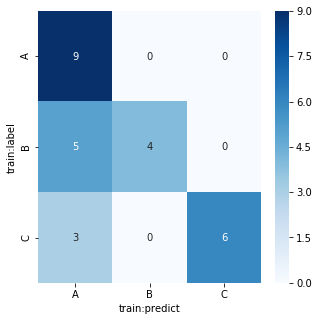

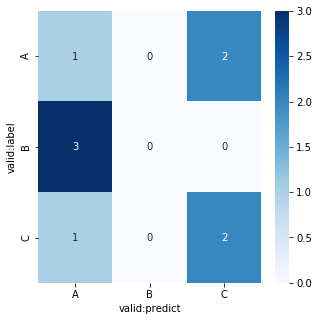

In [66]:
import pandas as pd
import seaborn as sn
def show_confusion_matrix(confmat, dataType):
    df_cm = pd.DataFrame(confmat, index = [i for i in "ABC"],
                  columns = [i for i in "ABC"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
    plt.xlabel(dataType + ':predict')        
    plt.ylabel(dataType + ':label')
    plt.savefig("./others/" + dataType + ".png")
    plt.show()


label = dict((v,k) for k,v in train_batches.class_indices.items())
train_report = classification_report(train_label, train_pred, target_names=['A', 'B', 'C'])
train_accuracy = accuracy_score(train_label, train_pred)
valid_report = classification_report(valid_label, valid_pred, target_names=['A', 'B', 'C'])
valid_accuracy = accuracy_score(valid_label, valid_pred)
train_mat = confusion_matrix(train_label, train_pred)
valid_mat = confusion_matrix(valid_label, valid_pred)

print("[train reports]")
print(train_report, "{:>10}{:11.2f}".format("accuracy", train_accuracy))
print('')
print("[valid reports]")
print(valid_report, "{:>10}{:11.2f}".format("accuracy", valid_accuracy))

show_confusion_matrix(train_mat, 'train')
show_confusion_matrix(valid_mat, 'valid')




## testing

In [180]:
test_batches.reset()
pred = model.predict_generator(generator=test_batches, verbose=1)

labels = (train_batches.class_indices)
label = dict((v,k) for k,v in labels.items())

filename = test_batches.filenames
pred_label = np.argsort(pred, axis=1)[:, ::-1][:, :3]
for i in range(15):
    print('{:<20}'.format(filename[i]), end='')
    for j in pred_label[i]:
        print(label[j], end='')
        print("%7.2f%%  " % (pred[i, j] * 100), end='')
    print('')

15/15 [==============================] - 4s 260ms/step
test/IMG_6509.JPG   B  51.92%  A  48.05%  C   0.03%  
test/IMG_6520.JPG   A  99.81%  B   0.14%  C   0.05%  
test/IMG_6578.JPG   A  98.81%  C   1.19%  B   0.00%  
test/IMG_6611.JPG   A  71.87%  B  27.69%  C   0.44%  
test/IMG_6612.JPG   A  99.93%  C   0.06%  B   0.01%  
test/bn.JPG         A  99.99%  B   0.01%  C   0.00%  
test/h.JPG          B  87.05%  A  12.94%  C   0.01%  
test/hg.JPG         C  69.44%  A  30.56%  B   0.00%  
test/jl.JPG         A  94.20%  B   5.74%  C   0.06%  
test/lo.JPG         C  99.49%  A   0.51%  B   0.00%  
test/s.JPG          A  99.96%  C   0.03%  B   0.01%  
test/u.JPG          A  99.93%  B   0.05%  C   0.02%  
test/v.JPG          A  99.91%  B   0.09%  C   0.00%  
test/w.JPG          B  76.19%  A  22.80%  C   1.00%  
test/z.JPG          A  78.57%  B  21.35%  C   0.08%  


## Others 

In [ ]:
# create model
model = ResNet152()
print(model.get_config())
# define function for input preprocessing
def preprocess(x):
    x = resize(x, (224,224), mode='constant') * 255
    x = preprocess_input(x)
    if x.ndim == 3:
        x = np.expand_dims(x, 0)
    return x

# prepare image
img = imread('./cat.jpg')
x = preprocess(img)

# make prediction and decode it
y = model.predict(x)
pred_title = decode_predictions(y, top=1)[0][0][1]

# print result
print(pred_title)